In [1]:
from nltk.corpus import PlaintextCorpusReader

conditions_path = "../Data/Conditions/"
NUMBER_OF_TOPICS = 5

?PlaintextCorpusReader
condition_books_train = PlaintextCorpusReader(conditions_path + "Train/", '.*.txt')
condition_books_test = PlaintextCorpusReader(conditions_path + "Test/", '.*.txt')

Init signature:
PlaintextCorpusReader(
    root,
    fileids,
    word_tokenizer=WordPunctTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL),
    sent_tokenizer=<nltk.tokenize.punkt.PunktSentenceTokenizer object at 0x0000014849623D00>,
    para_block_reader=<function read_blankline_block at 0x0000014849646940>,
    encoding='utf8',
)
Docstring:     
Reader for corpora that consist of plaintext documents.  Paragraphs
are assumed to be split using blank lines.  Sentences and words can
be tokenized using the default tokenizers, or by custom tokenizers
specified as parameters to the constructor.

This corpus reader can be customized (e.g., to skip preface
sections of specific document formats) by creating a subclass and
overriding the ``CorpusView`` class variable.
Init docstring:
Construct a new plaintext corpus reader for a set of documents
located at the given root directory.  Example usage:

    >>> root = '/usr/local/share/nlt

We need to update our condition dictionary to work with the bookids

In [2]:
condition_books_dict = {f:n for n,f in enumerate(condition_books_train.fileids())}

In [3]:
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

chunks_train = list()
chunks_test = list()
chunk_train_class = list()
chunk_test_class = list()

limit = 500
size = 50

for f in condition_books_train.fileids():
    ################# For Training chunks ####################################
    print("TRAINING CHUNK: ")
    sentences = condition_books_train.sents(f)
    print(f,":")
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()

    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks_train.extend(chs[:limit])
    chunk_train_class.extend([condition_books_dict[f] for _ in range(len(chs[:limit]))])
    ################ For Test chunks ############################################
    print("TESTING CHUNK: ")
    sentences = condition_books_test.sents(f)
    print(f,":")
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()

    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks_test.extend(chs[:limit])
    chunk_test_class.extend([condition_books_dict[f] for _ in range(len(chs[:limit]))])

TRAINING CHUNK: 
acne.txt :
Number of sentences: 31042
Number of chunks: 621 

TESTING CHUNK: 
acne.txt :
Number of sentences: 10502
Number of chunks: 211 

TRAINING CHUNK: 
anxiety.txt :
Number of sentences: 29236
Number of chunks: 585 

TESTING CHUNK: 
anxiety.txt :
Number of sentences: 9428
Number of chunks: 189 

TRAINING CHUNK: 
birthcontrol.txt :
Number of sentences: 170167
Number of chunks: 3404 

TESTING CHUNK: 
birthcontrol.txt :
Number of sentences: 57036
Number of chunks: 1141 

TRAINING CHUNK: 
depression.txt :
Number of sentences: 49024
Number of chunks: 981 

TESTING CHUNK: 
depression.txt :
Number of sentences: 16945
Number of chunks: 339 

TRAINING CHUNK: 
pain.txt :
Number of sentences: 24509
Number of chunks: 491 

TESTING CHUNK: 
pain.txt :
Number of sentences: 8264
Number of chunks: 166 



Now we are going to make a pipeline to process the chunks we are going to find named entities and add them if they are compound, keep only words, lemmatize tokens, remove punctuation and stopwords

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')

STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_reviews = list()
for review_doc in nlp.pipe(chunks_train, n_process=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = review_doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    review_doc = [token.lemma_ for token in review_doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    review_doc = [token for token in review_doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than one word.
    review_doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_reviews.append(review_doc)

Now we are going to add to our docs the bigrams that appear at least 15 times, as there could be 2 coorelated words that might be more meaningful together

In [5]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(processed_reviews, min_count=15)

for idx in range(len(processed_reviews)):
    for token in bigram[processed_reviews[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            processed_reviews[idx].append(token)

C:\Users\javi\anaconda3\envs\data_science\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Now we are going to filter words that appear under a min count and words that could have a too high frequency rate, then we will create our bag of words!

In [6]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(processed_reviews)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in processed_reviews]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 8094
Number of chunks: 2491


Now we are going to feed a Latent Dirichlet Allocation (LDA) ML technique with our information and see the results!

In [7]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': 42}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=NUMBER_OF_TOPICS, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [8]:
model.show_topics(num_words=NUMBER_OF_TOPICS)

[(0,
  '0.009*"attack" + 0.009*"panic" + 0.005*"Lexapro" + 0.005*"panic_attack" + 0.004*"Xanax"'),
 (1,
  '0.007*"period" + 0.004*"birth_control" + 0.004*"birth" + 0.004*"acne" + 0.003*"patch"'),
 (2,
  '0.028*"acne" + 0.020*"skin" + 0.018*"period" + 0.011*"face" + 0.011*"clear"'),
 (3,
  '0.006*"skin" + 0.005*"acne" + 0.004*"face" + 0.003*"clear" + 0.002*"attack"'),
 (4,
  '0.013*"acetaminophen" + 0.009*"relief" + 0.008*"surgery" + 0.006*"patch" + 0.006*"chronic"')]

In [9]:
for i in range(0,NUMBER_OF_TOPICS):
    print("CONDITION ", list(condition_books_dict.keys())[list(condition_books_dict.values()).index(i)])
    print(model.show_topic(i,5))
    # Plot as histogram

CONDITION  acne.txt
[('attack', 0.009026211), ('panic', 0.008697217), ('Lexapro', 0.0054196375), ('panic_attack', 0.0051656407), ('Xanax', 0.0044750813)]
CONDITION  anxiety.txt
[('period', 0.007192596), ('birth_control', 0.0037545327), ('birth', 0.0036864348), ('acne', 0.003549174), ('patch', 0.0029663928)]
CONDITION  birthcontrol.txt
[('acne', 0.027943557), ('skin', 0.019854289), ('period', 0.017712537), ('face', 0.011434408), ('clear', 0.010659047)]
CONDITION  depression.txt
[('skin', 0.006372084), ('acne', 0.0054069962), ('face', 0.0041439813), ('clear', 0.0026818104), ('attack', 0.002378531)]
CONDITION  pain.txt
[('acetaminophen', 0.012522405), ('relief', 0.009347642), ('surgery', 0.008012307), ('patch', 0.0061608953), ('chronic', 0.005998852)]


In [10]:
import pyLDAvis.gensim
# plot topics
data =  pyLDAvis.gensim.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

C:\Users\javi\anaconda3\envs\data_science\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [13]:
# assignment
sent_to_cluster = list()
for n,doc in enumerate(corpus):
    if doc:
        cluster = max(model[doc],key=lambda x:x[1])
        sent_to_cluster.append(cluster[0])

In [14]:
# accuracy
from collections import Counter
for condition_book, cluster in condition_books_dict.items():
    assignments = list()
    for real,given in zip(chunk_train_class,sent_to_cluster):
        if real == cluster:
            assignments.append(given)
    most_common,num_most_common = Counter(assignments).most_common(1)[0] # 4, 6 times
    print(condition_book,":",most_common,"-",num_most_common)
    print("Accuracy:",num_most_common/limit)
    print("------")

acne.txt : 2 - 500
Accuracy: 1.0
------
anxiety.txt : 0 - 500
Accuracy: 1.0
------
birthcontrol.txt : 2 - 497
Accuracy: 0.994
------
depression.txt : 0 - 500
Accuracy: 1.0
------
pain.txt : 4 - 491
Accuracy: 0.982
------


# Text classification

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.utils import shuffle

# Identify :
SEARCH_ID = 3
vectorizer = CountVectorizer()

#initialize and specify minumum number of occurences to avoid untractable number of features
#vectorizer = CountVectorizer(min_df = 2) if we want high frequency

#create bag of words features
X_train = vectorizer.fit_transform(chunks_train)
X_test = vectorizer.fit_transform(chunks_test)

print('Number of samples:',X_test.toarray().shape[0] + X_train.toarray().shape[0])
print('Number of features:',X_train.toarray().shape[1])

Y_train = np.array(chunk_train_class) == SEARCH_ID
Y_train = Y_train.astype(int) 
Y_test = np.array(chunk_test_class) == SEARCH_ID
Y_test = Y_test.astype(int) 

#shuffle the data
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

Number of samples: 3896
Number of features: 21412


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
accs = []

#the grid of regularization parameter 
grid = [0.01,0.1,1,10,100,1000,10000]

for c in grid:
    
    #initialize the classifier
    clf = LogisticRegression(random_state=0, solver='newton-cg',C = c)
    
    #crossvalidate
    scores = cross_val_score(clf, X_train,Y_train, cv=10)
    accs.append(np.mean(scores))

(0.986, 1.0)

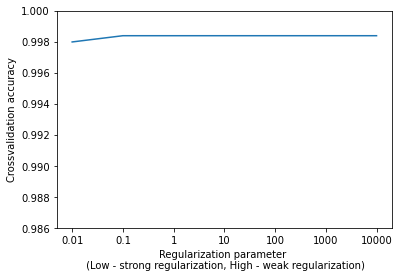

In [38]:
import matplotlib.pyplot as plt
plt.plot(accs)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Regularization parameter \n (Low - strong regularization, High - weak regularization)')
plt.ylabel('Crossvalidation accuracy')
plt.ylim([0.986,1])

In [39]:
X_train

<2491x21412 sparse matrix of type '<class 'numpy.int64'>'
	with 892058 stored elements in Compressed Sparse Row format>

In [40]:
# lets grab max cross calidation score value index
np.array(accs).argmax()

1

In [42]:
# this is our best regularization value
grid[1]

0.1

In [44]:
# write your code here:
C_reg = grid[3]


clf = LogisticRegression(random_state=0, solver='newton-cg',C = C_reg).fit(X_train,Y_train)

#predict on the test set
print('Accuracy:',clf.score(X_test,Y_test))

ValueError: X has 16564 features, but LogisticRegression is expecting 21412 features as input.

(1405, 16564)